# TSFRESH Human Activity Recognition Example
This example show shows how to use [tsfresh](https://tsfresh.readthedocs.io/) to exctract useful features from multiple timeseries and use them to improve classification performance.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
import seaborn as sns
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

import logging

/home/ds806/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# We set the logger to Error level
# This is not recommend for normal use as you can oversee important Warning messages
logging.basicConfig(level=logging.ERROR)

## Load and visualize data
The dataset consists of timeseries for 7352 accelerometer readings. Each reading represents an accelerometer reading for 2.56 sec at 50hz (for a total of 128 samples per reading). Furthermore, each reading corresponds one of six activities (walking, walking upstairs, walking downstairs, sitting, standing and laying)

For more information, or to fetch dataset, go to https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [3]:
# fetch dataset from uci
download_har_dataset()

In [4]:
df = load_har_dataset()
df.head()
df.shape

(7352, 128)

/home/ds806/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


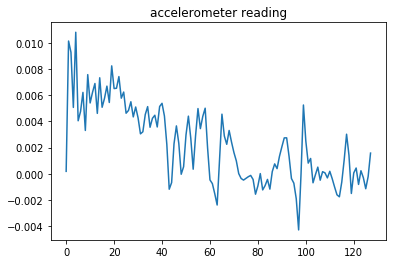

In [5]:
plt.title('accelerometer reading')
plt.plot(df.ix[0,:])
plt.show()

## Extract Features

In [6]:
extraction_settings = ComprehensiveFCParameters()

In [7]:
# rearrange first 500 sensor readings column-wise, not row-wise

N = 500
master_df = pd.DataFrame({0: df[:N].values.flatten(),
                          1: np.arange(N).repeat(df.shape[1])})
master_df.head()

,0,1
0,0.000181,0
1,0.010139,0
2,0.009276,0
3,0.005066,0
4,0.010810,0


In [8]:
%time X = extract_features(master_df, column_id=1, impute_function=impute, default_fc_parameters=extraction_settings);

Feature Extraction: 100%|██████████| 56/56 [00:11<00:00,  5.03it/s]


CPU times: user 1.75 s, sys: 446 ms, total: 2.2 s
Wall time: 13.3 s


In [9]:
X.shape

(500, 794)

In [10]:
"Number of extracted features: {}.".format(X.shape[1])

'Number of extracted features: 794.'

## Train and evaluate classifier

In [11]:
y = load_har_classes()[:N]
y.shape

(500,)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [13]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       0.88      1.00      0.94        22
          2       1.00      0.89      0.94         9
          3       1.00      0.80      0.89        15
          4       0.41      0.37      0.39        19
          5       0.36      0.47      0.41        17
          6       0.44      0.39      0.41        18

avg / total       0.65      0.64      0.64       100



# Multiclass feature selection

In total our feature matrix contains 222 features. 
We can try to select a subset of features with the select_features method of tsfresh. 

However it only works for binary classification or regression tasks. 

For a 6 label multi classification we split the selection problem into 6 binary one-versus all classification problems. For each of them we can do a binary classification feature selection:

In [14]:
relevant_features = set()

for label in y.unique():
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train, y_train_binary)
    print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X_train.shape[1]))
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

Number of relevant features for class 5: 215/794
Number of relevant features for class 4: 205/794
Number of relevant features for class 6: 191/794
Number of relevant features for class 1: 217/794
Number of relevant features for class 3: 213/794
Number of relevant features for class 2: 161/794


In [15]:
len(relevant_features)

263

we keep only those features that we selected above, for both the train and test set

In [16]:
X_train_filtered = X_train[list(relevant_features)]
X_test_filtered = X_test[list(relevant_features)]

In [17]:
X_train_filtered.shape, X_test_filtered.shape

((400, 263), (100, 263))

so, we reduced the number of used features from 794 to 263

In [18]:
cl = DecisionTreeClassifier()
cl.fit(X_train_filtered, y_train)
print(classification_report(y_test, cl.predict(X_test_filtered)))

             precision    recall  f1-score   support

          1       0.88      1.00      0.94        22
          2       1.00      1.00      1.00         9
          3       1.00      0.80      0.89        15
          4       0.47      0.47      0.47        19
          5       0.43      0.53      0.47        17
          6       0.57      0.44      0.50        18

avg / total       0.70      0.69      0.69       100



It worked! The precision improved by removing irrelevant features.

## Compare against naive classification accuracy
By extracting using time-series features (as opposed to using raw data points), we can meaningfully increase classification accuracy.

In [19]:
X_1 = df.ix[:N-1,:]
X_1.shape

(500, 128)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=.2)

In [21]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       0.67      0.62      0.64        26
          2       0.79      0.58      0.67        19
          3       0.50      0.67      0.57        12
          4       0.29      0.42      0.34        12
          5       0.40      0.40      0.40        15
          6       0.36      0.31      0.33        16

avg / total       0.54      0.51      0.52       100



So, both our unfiltered and filtered feature based classificators are able to beat the model on the raw time series values 